# Prediction for Diabetes in Adult Females of Pima Indian Heritage

## 1. Introduction:

In the medical industry, the ability to efficiently and effectively detect and remedy diseases is crucial to improving a patient's health. Quite notably, the early detection of diabetes, a chronic metabolic disorder affecting millions worldwide, can prevent serious complications. Luckily, with advancements in data science we can create models to help predict whether a person has diabetes or not by employing the methods of classification. 

We hope to answer the question: Can we determine key identifiers to whether an adult female of Pima Indian heritage has diabetes, and whether using these specific identifiers produces a better model for prediction of diabetes in an adult female of Pima Indian heritage than using all the given predictors?

Using an existing data set from The National Institute of Diabetes and Digestive and Kidney Diseases, we will create a classification model to determine the answer to our question. All patients listed in this database are females over the age of 21 and of Pima Indian heritage. This data set consists of several medical predictors (independent) variables and one target (dependent) variable, Outcome. They have modeled the outcome on two class variables 0 (does not have diabetes) and 1 (has diabetes).


In [1]:
### run to install necessary libraries ###
library(repr)
library(tidyverse)
library(tidymodels)
#library(janitor)
install.packages("kknn")
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

## 2. Preliminary exploratory data analysis:

In [2]:
# read the data
diabetes <- read_csv("https://raw.githubusercontent.com/asnbl/dsci-100-2023-24W-group-16/main/diabetes.csv")

diabetes

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,121,72,23,112,26.2,0.245,30,0
1,126,60,0,0,30.1,0.349,47,1
1,93,70,31,0,30.4,0.315,23,0


**Table 1 : Original Diabetes Data Set**

In [3]:
# tidy and wrangle data
diabetes_clean <- diabetes |>
    mutate(Outcome = as_factor(Outcome)) |>
    rename("Diabetes" = Outcome) |> 
    mutate(Diabetes = fct_recode(Diabetes, "yes" = "1", "no"  = "0")) |>
    mutate(across(.cols = -Pregnancies, ~replace(., . == 0, NA)))

head(diabetes_clean)

diabetes_split <- initial_split(diabetes_clean, prop = 0.75, strata = Diabetes)
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split) 

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,NA,33.6,0.627,50,yes
1,85,66,29,NA,26.6,0.351,31,no
8,183,64,NA,NA,23.3,0.672,32,yes
1,89,66,23,94,28.1,0.167,21,no
0,137,40,35,168,43.1,2.288,33,yes
5,116,74,NA,NA,25.6,0.201,30,no


**Table 2 : Cleaned Diabetes Data Set**

Looking at the original data, there was not a lot that had to be done to tidy the data. However, to make the data easier for the average consumer to interpret, we decided to rename 'Outcome' to 'Diabetes' and refactor its values as "yes" and "no", rather than 1 and 0. After that, we then replaced all 0 values which are not in pregnancies with NA as those 0 values are representative of a lack of a measurement.

### Summarizing the Data

Here, we will summarize properties of our training data, like the proportion of people with diabetes vs no diabetes, means of predictors, and amount of NA values.

In [4]:
# summary
diabetes_proportions <- diabetes_train |>
    group_by(Diabetes) |>
    summarize(count = n()) |>
    mutate(percent = 100*count/nrow(diabetes_train))

diabetes_proportions

Diabetes,count,percent
<fct>,<int>,<dbl>
no,375,65.10417
yes,201,34.89583


**Table 3 : Diabetes Proportions**

From the data frame above, we can see that around 65% of our training data does not have diabetes, and around 35% does.
**Since the class of no diabetes represents the majority of the training data, the majority classifier would always predict that a new observation has diabetes. The estimated accuracy of the majority classifier is usually fairly close to the majority class proportion in the training data. In this case, we would suspect that the majority classifier will have an accuracy of around NA%.**

In [5]:
predictor_means <- diabetes_train |>
    na.omit() |>
    select(-Diabetes) |>
    map_df(mean)

predictor_means

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.344482,120.7592,70.63211,28.65886,149.4181,32.72709,0.4978829,31.04013


**Table 4 : Mean of the Predictors**

In the above data frame, the average value for each predictor is displayed. 

In [6]:
missing_count <- sum(is.na(diabetes_train))

missing_count
dim(diabetes_train)

[1] 482

[1] 576   9

The top number represents how many NA values are in our training data set. Considering that there are 5184 (576 x 9) values, having around 10% be NA should not impact our results too significantly.

### Visualizing the Data

It is important to use summary tables and visualizations to analyze distributions between groups. Here, we will use box plots to look at relationship between the predictor variable and the response variable to do feature selection and narrow down the number of predictor variables we want to use.

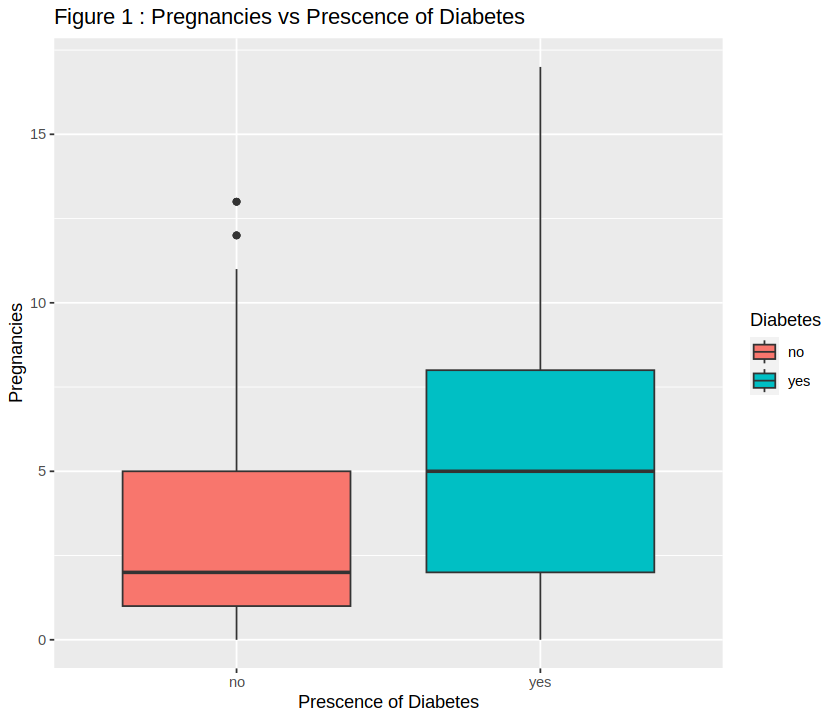

In [18]:
# Set options for plot width and height
options(repr.plot.width = 7, repr.plot.height = 6)

pregnancies <- ggplot(diabetes_train, aes(x = Diabetes, y = Pregnancies, fill = Diabetes)) +
        geom_boxplot() +
        labs( x = "Prescence of Diabetes", y = "Pregnancies") +
        ggtitle("Figure 1 : Pregnancies vs Prescence of Diabetes")

pregnancies

The plot is a box plot comparing the number of pregnancies between individuals with and without diabetes, indicating a higher median number of pregnancies in individuals with diabetes.

Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”


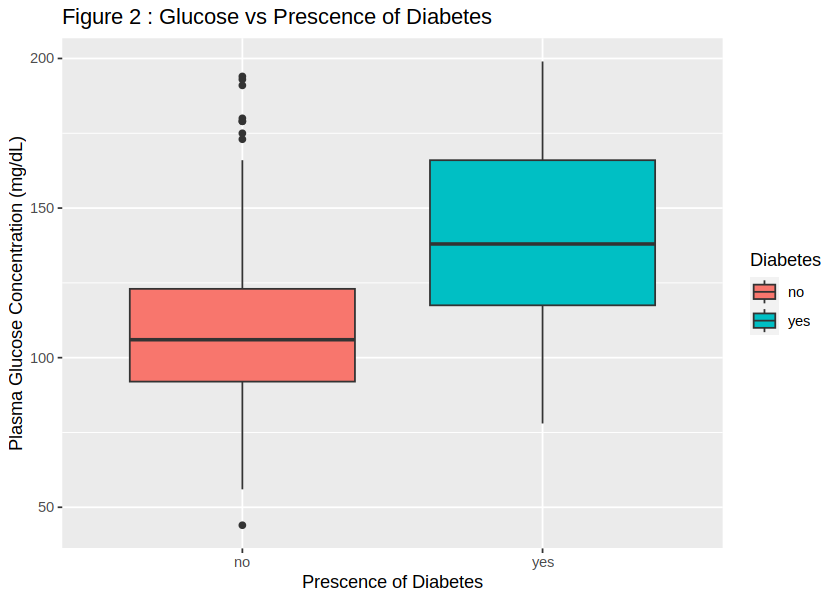

In [19]:
# Set options for plot width and height
options(repr.plot.width = 7, repr.plot.height = 5)

glucose <- ggplot(diabetes_train, aes(x = Diabetes, y = Glucose, fill = Diabetes)) +
        geom_boxplot() +
        labs( x = "Prescence of Diabetes", y = "Plasma Glucose Concentration (mg/dL)") +
        ggtitle("Figure 2 : Glucose vs Prescence of Diabetes")
glucose

The plot is a box plot displaying the distribution of plasma glucose concentrations, showing higher levels in individuals with diabetes compared to those without.

Warning message:
“Removed 27 rows containing non-finite values (`stat_boxplot()`).”


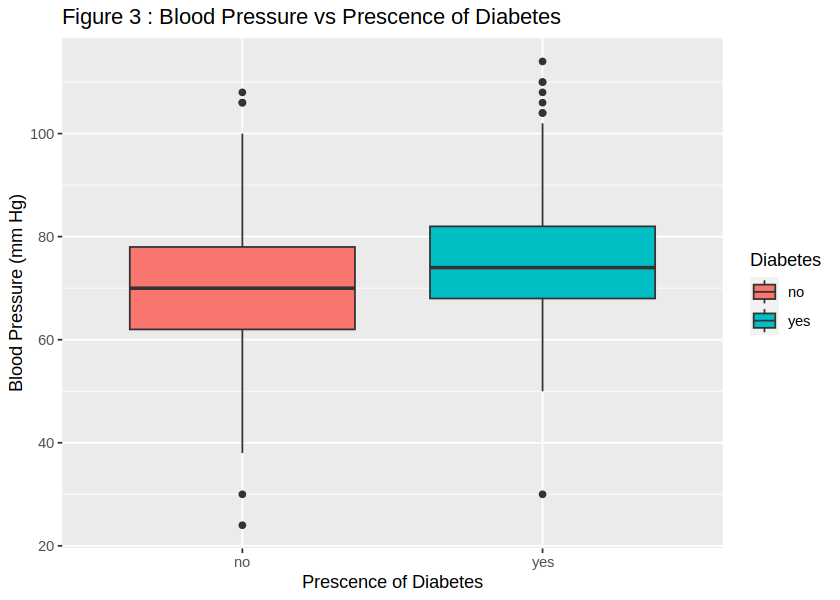

In [20]:
# Set options for plot width and height
options(repr.plot.width = 7, repr.plot.height = 5)

blood_pressure <- ggplot(diabetes_train, aes(x = Diabetes, y = BloodPressure, fill = Diabetes)) +
        geom_boxplot() +
        labs( x = "Prescence of Diabetes", y = "Blood Pressure (mm Hg)") +
        ggtitle("Figure 3 : Blood Pressure vs Prescence of Diabetes")
blood_pressure

The plot is a box plot showing blood pressure distribution with generally higher values in individuals diagnosed with diabetes compared to those without diabetes.

Warning message:
“Removed 167 rows containing non-finite values (`stat_boxplot()`).”


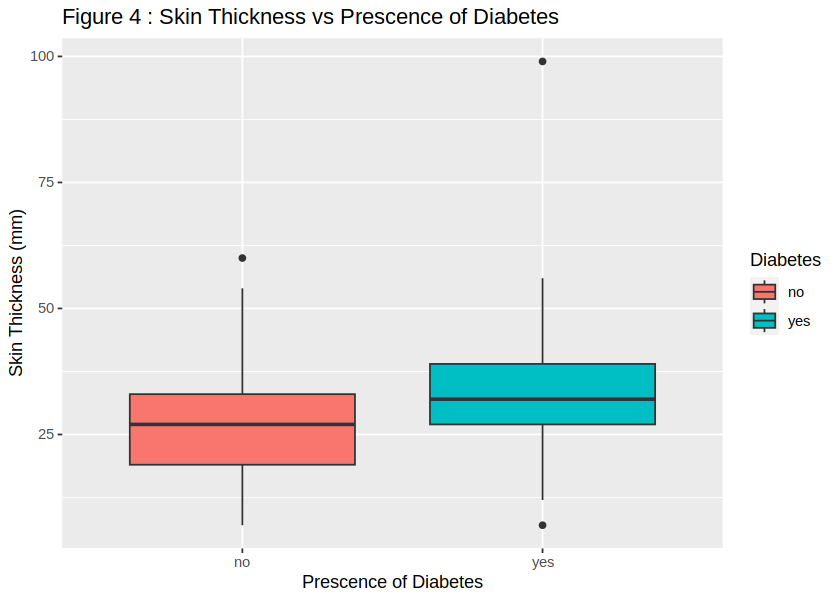

In [21]:
# Set options for plot width and height
options(repr.plot.width = 7, repr.plot.height = 5)

skin_thickness <- ggplot(diabetes_train, aes(x = Diabetes, y = SkinThickness, fill = Diabetes)) +
        geom_boxplot() +
        labs( x = "Prescence of Diabetes", y = "Skin Thickness (mm)") +
        ggtitle("Figure 4 : Skin Thickness vs Prescence of Diabetes")
skin_thickness

The plot is a box plot comparing skin thickness measurements, showing a slightly higher median skin thickness in individuals with diabetes compared to those without.

Warning message:
“Removed 276 rows containing non-finite values (`stat_boxplot()`).”


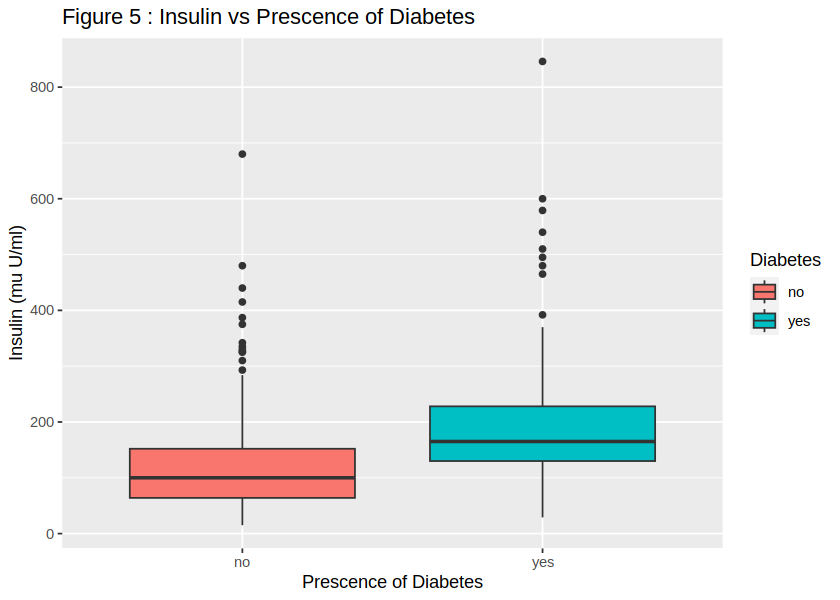

In [22]:
# Set options for plot width and height
options(repr.plot.width = 7, repr.plot.height = 5)

insulin <- ggplot(diabetes_train, aes(x = Diabetes, y = Insulin, fill = Diabetes)) +
        geom_boxplot() +
        labs( x = "Prescence of Diabetes", y = "Insulin (mu U/ml)") +
        ggtitle("Figure 5 : Insulin vs Prescence of Diabetes")
insulin

The plot is a box plot showing that individuals with diabetes have a wider range and higher median insulin levels compared to those without diabetes.

Warning message:
“Removed 8 rows containing non-finite values (`stat_boxplot()`).”


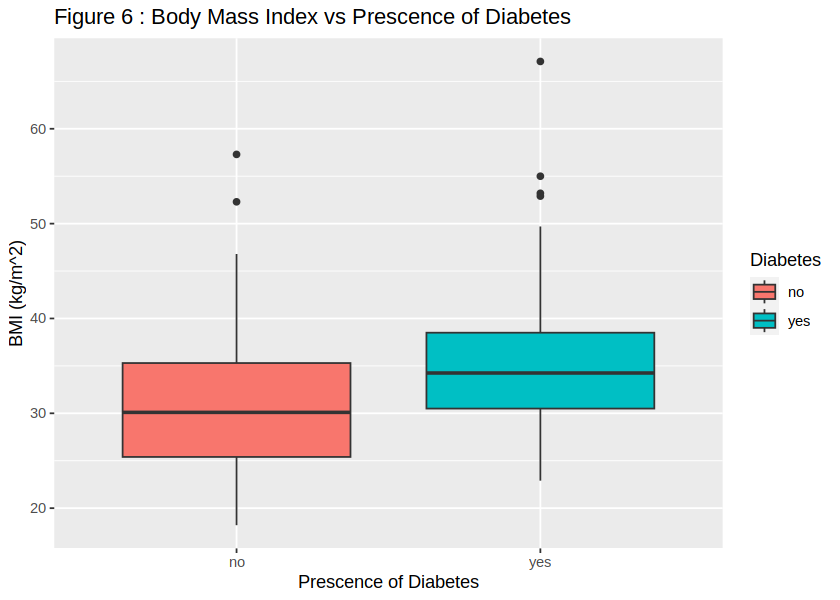

In [23]:
# Set options for plot width and height
options(repr.plot.width = 7, repr.plot.height = 5)

BMI <- ggplot(diabetes_train, aes(x = Diabetes, y = BMI, fill = Diabetes)) +
        geom_boxplot() + 
        labs( x = "Prescence of Diabetes", y = "BMI (kg/m^2)") +
        ggtitle("Figure 6 : Body Mass Index vs Prescence of Diabetes")
BMI

The plot is a box plot illustrating that individuals with diabetes tend to have higher Body Mass Index (BMI) values than those without diabetes.

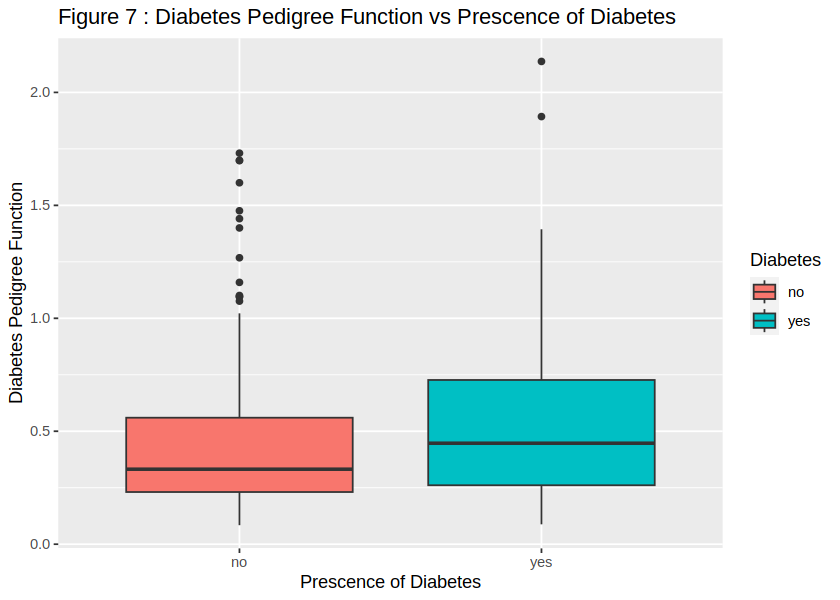

In [24]:
# Set options for plot width and height
options(repr.plot.width = 7, repr.plot.height = 5)

diabetes_pedigree_fn <- ggplot(diabetes_train, aes(x = Diabetes, y = DiabetesPedigreeFunction, fill = Diabetes)) +
        geom_boxplot() + 
        labs( x = "Prescence of Diabetes", y = "Diabetes Pedigree Function") +
        ggtitle("Figure 7 : Diabetes Pedigree Function vs Prescence of Diabetes")
diabetes_pedigree_fn

The plot is a box plot showing that the values of the Diabetes Pedigree Function are higher on average for individuals with diabetes than for those without.

### Overall Conclusion

From the above graphs, it can be seen that the predictors with the least overlap between the boxes for each of the two response variables are glucose and insulin. This means a model using glucose and insulin as predictors will most likely produce the best results.

## Making the Model(s)
### Using only Glucose and Insulin

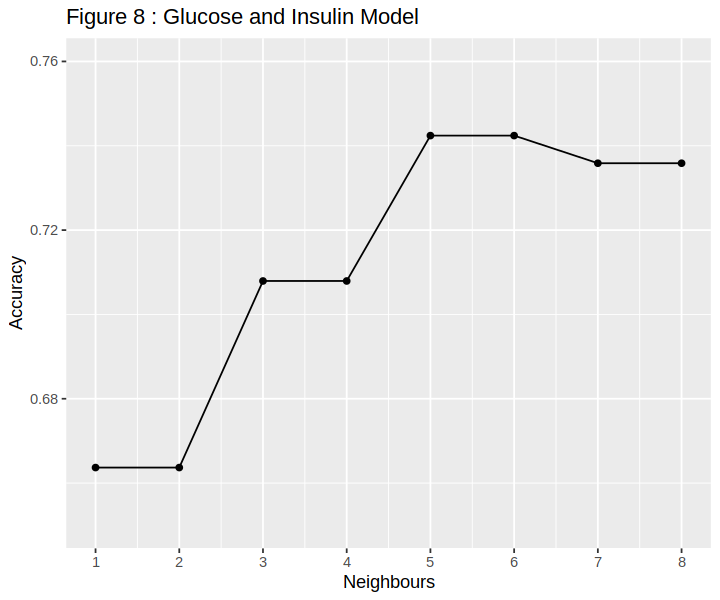

In [25]:
# Using only glucose and insulin
# Set the seed
set.seed(1000) 

options(repr.plot.height = 5, repr.plot.width = 6)

dia1_split <- diabetes_clean |>
            select(Glucose, Insulin, Diabetes) |>
            na.omit() |>
            initial_split(prop = 0.75, strata = Diabetes)

dia1_train <- training(dia1_split)

dia1_test <- testing(dia1_split)

k_vals <- tibble(neighbors = seq(from = 1, to = 8))

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

dia1_recipe <- recipe(Diabetes ~., data = dia1_train) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

dia1_vfold <- vfold_cv(dia1_train, v = 5, strata = Diabetes)


dia1_results <- workflow() |>
            add_recipe(dia1_recipe) |>
            add_model(knn_spec) |>
            tune_grid(resamples = dia1_vfold, grid = k_vals) |>
            collect_metrics() 

cross_val_plot <- filter(dia1_results, .metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy") +
    scale_x_continuous(breaks = seq(0, 20)) +
    scale_y_continuous(limits = c(0.65, 0.76)) +
    ggtitle("Figure 8 : Glucose and Insulin Model")

cross_val_plot

From this it can be seen that the optimal k-value appears to be either 5 or 6. For our model, we will choose 5 as we have 2 classes, and therefore using an odd number will remove the possibility of a tie.

In [15]:
# Using only glucose and insulin
# Set the seed
set.seed(1000) 

dia1_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
            set_engine("kknn") |>
            set_mode("classification")

dia1_fit <- workflow() |>
            add_recipe(dia1_recipe) |>
            add_model(dia1_spec) |>
            fit(data = dia1_train) 

dia1_predictions <- predict(dia1_fit, dia1_test) |>
                    bind_cols(dia1_test)

dia1_metrics <- dia1_predictions |> metrics(truth = Diabetes, estimate = .pred_class) |>
                filter(.metric == "accuracy")

dia1_conf_mat <- dia1_predictions |>
                 conf_mat(truth = Diabetes, estimate = .pred_class) 

dia1_predictions
dia1_metrics
dia1_conf_mat

.pred_class,Glucose,Insulin,Diabetes
<fct>,<dbl>,<dbl>,<fct>
no,143,146,yes
yes,158,245,yes
yes,111,207,yes
⋮,⋮,⋮,⋮
no,128,110,yes
no,101,180,no
no,121,112,no


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7373737


          Truth
Prediction no yes
       no  59  19
       yes  7  14

**Table 5 : Predictions using Glucose and Insulin**

Here, we can see that the model trained on just insulin and glucose as predictors has an accuracy estimate of 73.7%.
It can also be observed that the classifier predicted a higher amount of yes classes predicted incorrectly as no which is corroborates with the original distribution of yes and no classes we had in the training data (65% no, 35% yes).

### Visualization

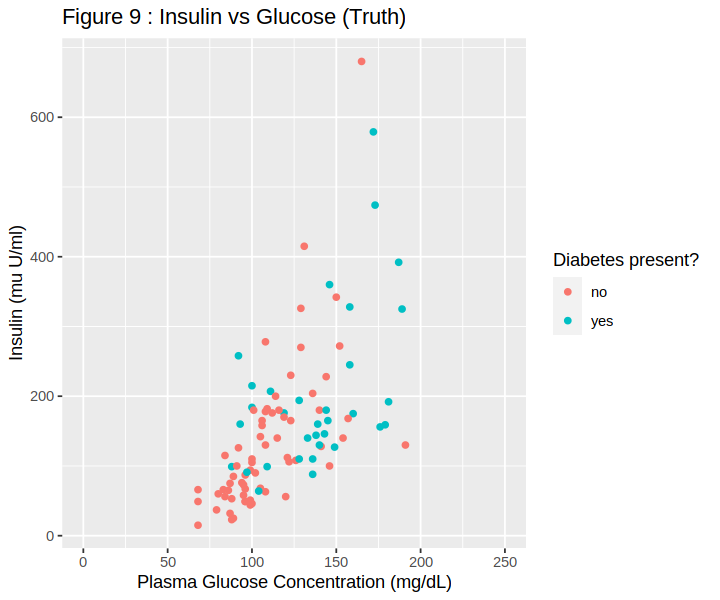

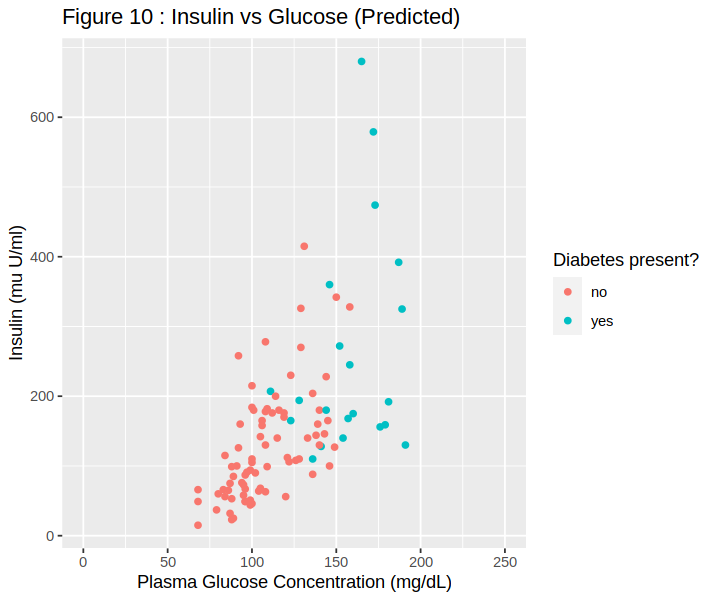

In [27]:
# Graph of Insulin and Glucose

dia1_truth_graph <- ggplot(dia1_predictions, aes(x = Glucose, y = Insulin, color = Diabetes)) +
        geom_point() +
        labs(x = "Plasma Glucose Concentration (mg/dL)", y = "Insulin (mu U/ml)", color = "Diabetes present?") +
        ggtitle("Figure 9 : Insulin vs Glucose (Truth)") +
        scale_x_continuous(limits = c(0, 250))

dia1_pred_graph <- ggplot(dia1_predictions, aes(x = Glucose, y = Insulin, color = .pred_class)) +
        geom_point() +
        labs(x = "Plasma Glucose Concentration (mg/dL)", y = "Insulin (mu U/ml)", color = "Diabetes present?") +
        ggtitle("Figure 10 : Insulin vs Glucose (Predicted)") +
        scale_x_continuous(limits = c(0, 250)) 

dia1_truth_graph
dia1_pred_graph

Above is a visualization of the model and what it predicts.

### Using all Given Predictors

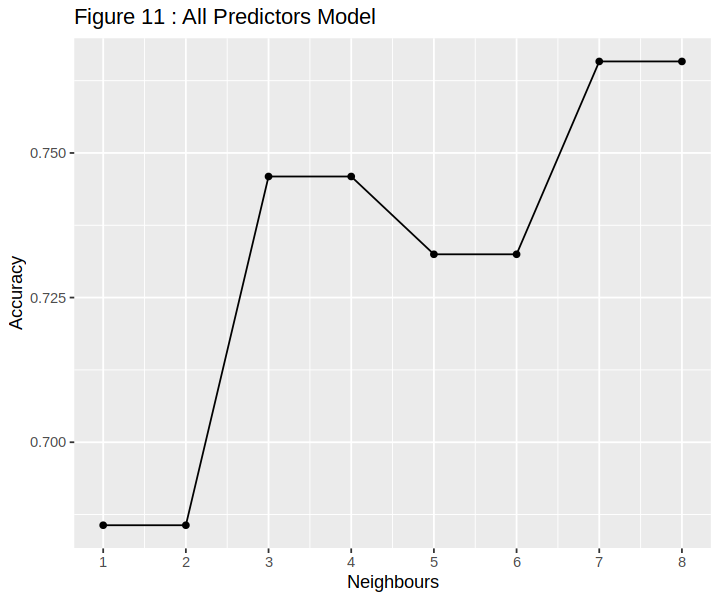

In [31]:
# Using all predictors
# Set the seed
set.seed(1000) 

options(repr.plot.height = 5, repr.plot.width = 6)

dia2_train <- na.omit(diabetes_train)

dia2_test <- na.omit(diabetes_test)

dia2_recipe <- recipe(Diabetes ~., data = dia2_train) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

dia2_vfold <- vfold_cv(dia2_train, v = 5, strata = Diabetes)


dia2_results <- workflow() |>
            add_recipe(dia2_recipe) |>
            add_model(knn_spec) |>
            tune_grid(resamples = dia2_vfold, grid = k_vals) |>
            collect_metrics() 

cross_val_plot <- filter(dia2_results, .metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy") +
    scale_x_continuous(breaks = seq(0, 20)) +
    ggtitle("Figure 11 : All Predictors Model")

cross_val_plot

From this it can be seen that the optimal k-value appears to be either 5 or 6 again. For our model, we will choose 5 as we have 2 classes, and therefore using an odd number will remove the possibility of a tie.

In [32]:
# Using all predictors
# Set the seed
set.seed(1000) 

dia2_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
            set_engine("kknn") |>
            set_mode("classification")

dia2_fit <- workflow() |>
            add_recipe(dia2_recipe) |>
            add_model(dia2_spec) |>
            fit(data = dia2_train) 

dia2_predictions <- predict(dia2_fit, dia2_test) |>
                    bind_cols(dia2_test)

dia2_metrics <- dia2_predictions |> metrics(truth = Diabetes, estimate = .pred_class) |>
                filter(.metric == "accuracy")

dia2_conf_mat <- dia2_predictions |>
                 conf_mat(truth = Diabetes, estimate = .pred_class) 
dia2_metrics
dia2_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7096774


          Truth
Prediction no yes
       no  50  19
       yes  8  16

**Table 6 : Predictions using all the predictors**

As we can see, the model produces less accurate results when using all the predictors to train the model, with the accuracy being 68.9% compared to the earlier 73.7%.

We did not create a visualization for this one as there are too many predictors to graph.

**Methods:**

1. First, the foundation for building a good classification prediction model is to load the correct libraries and read the data using the read_csv() function.

2. Next, we plan to clean and wrangle the data. The data is already tidy, so to make the data easier for the average consumer to interpret, we decided to rename 'Outcome' to 'Diabetes' and refactor its values as "yes" and "no", rather than 1 and 0, respectively. After that, we then replaced all 0 values which are not in pregnancies with NA as those 0 values are representative of a lack of a measurement.
3. Now we split the data into training and testing sets. 
4. Then, using our training data set we will summarize properties of our training data, like the proportion of people with diabetes vs no diabetes, means of predictors, and amount of NA values to get an idea of what our data set looks like.
5. Next, we can narrow down the best predictors for diabetes by plotting the predictors against each class (yes or no diabetes) in box plots.
6. We discovered that glucose, insulin, and BMI appear to have the least overlap and therefore are the most different between classes. Using these specific predictors we will make a knn classification model and then compare it with a knn classification model made using all the given predictors.
7. For each knn classification model, we first combined pre-processing and model training using a workflow. Then by tuning and using cross-validation, we determined the optimal k-value to use for our classifier. 
8. Finally, we can test each model’s accuracy on the test data that the classifier was not trained on and compare the results.

**Expected outcomes and significance:**

From our model, we expect to find whether or not a woman of Pima Indian ancestry has diabetes. We will do that by taking a point on the plot and with the help of our predictors (glucose levels and BMI) make our prediction. We anticipate discovering whether these specific characteristics are positively or negatively associated with the occurrence of diabetes.

A model like this will not only contribute to the growing field of predictive medicine but also enhance the concept of preventive healthcare practices which can help improve the lives of millions who are susceptible to diabetes and timely intervention and adjustments to their lifestyle can aid in managing the condition and lowering the disease's risk.

After the model identifies individuals at high risk, we can then examine the efficiency of various intervention approaches, such as dietary and exercise programs, to determine which ones are the most effective in preventing diabetes.

**Data Sources:**

https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
